# Base model and data collection

In [1]:
!pip install pretty_midi

  Using cached pretty_midi-0.2.9.tar.gz (5.6 MB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.23.5-cp310-cp310-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached mido-1.2.10-py2.py3-none-any.whl (51 kB)
Using legacy 'setup.py install' for pretty_midi, since package 'wheel' is not installed.
  Running setup.py install for pretty_midi ... done

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pretty_midi as pm
import collections


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load data

In [ ]:
#Loading the list of chopin's midi files as stream 
filepath = os.path.join( "data", "raw_data", "chopin")
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)
        midi = pm.PrettyMIDI(tr)
        all_midis.append(midi)

In [ ]:
def bpm(midi_file):
  """returns most frequent bpm listed in midi file"""
  l, counts = np.unique(midi_file.get_tempo_changes()[1].round(), return_counts=True)
  return l[np.argmax(counts)]

In [ ]:
#Helping function        
def midi_to_notes(file) -> pd.DataFrame:
  """Turns midi file into dataframe containing 
  pitch, step, duration and velocity"""

  notes = collections.defaultdict(list)
  sorted_notes=[]
  for i in range(len(file.instruments)):
    # Sort the notes by start time
    sorted_notes += list(file.instruments[i].notes)

  sorted_notes = sorted(sorted_notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['start'].append(start)
    notes['pitch'].append(int(note.pitch))
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    notes['velocity'].append(note.velocity)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()}).sort_values(by=['start'])

In [ ]:
def notes_to_chords(df):
  """group notes played at the same time into chords.
  returns dataframe with pitch, start and step columns"""

  df['pitch'] = df['pitch'].apply(lambda x: str(x))
  df = df[['pitch', 'start', 'step', 'velocity', 'duration']].groupby('start', as_index=False).agg({'pitch':lambda x : '.'.join(x), 
                                                                                                    'step':'sum', 
                                                                                                    'velocity':'max', 
                                                                                                    'duration':'max'})
  return df

In [ ]:
def strongest_note(df):
  """group notes played at the sametime based on the stongest note played. 
  returns dataframe with pitch, start and step columns"""

  df = df[['pitch', 'start', 'step', 'velocity', 'duration']].groupby('start', as_index=False).agg({'pitch':lambda g: g[df.loc[g.index]['velocity'].idxmax()], 
                                                                            'step':'sum', 
                                                                            'velocity':'max', 
                                                                            'duration':'max'})
  return df

In [ ]:
processed_files = [strongest_note(midi_to_notes(file))[['pitch', 'step', 'velocity', 'duration']] for file in all_midis]

In [ ]:
sample_files = pd.concat(processed_files).reset_index().drop(columns='index')

In [ ]:
sample_files['pitch'] = sample_files['pitch']-21

In [ ]:
sample_files.to_csv(os.path.join("data", "processed_data", 
                                 "processed_data.csv"))

##Data exploration

In [ ]:
sample_files

,pitch,step,velocity,duration
0,43,0.000000,60,0.813449
1,43,0.813449,60,0.610087
2,43,0.610087,57,0.203362
3,43,0.203362,60,0.813449
4,44,0.813449,58,0.813449
...,...,...,...,...
43471,35,0.698126,50,0.388533
43472,40,0.809819,51,0.460074
43473,44,0.966809,58,3.243243
43474,35,3.243243,27,14.950559


In [ ]:
pitches = sample_files['pitch']

In [ ]:
un_notes, counts = np.unique(pitches, return_counts=True)
print("Total unique notes in the Corpus:", un_notes.shape[0])

Total unique notes in the Corpus: 76


In [ ]:
#Average recurrenc for a note in Corpus
def Average(array):
    return sum(array) / len(array)
print("Average recurrence for a note in Corpus:", Average(counts))
print("Most frequent note in Corpus appeared:", max(counts), "times")
print("Least frequent note in Corpus appeared:", min(counts), "times")

Average recurrence for a note in Corpus: 572.0526315789474
Most frequent note in Corpus appeared: 1760 times
Least frequent note in Corpus appeared: 4 times


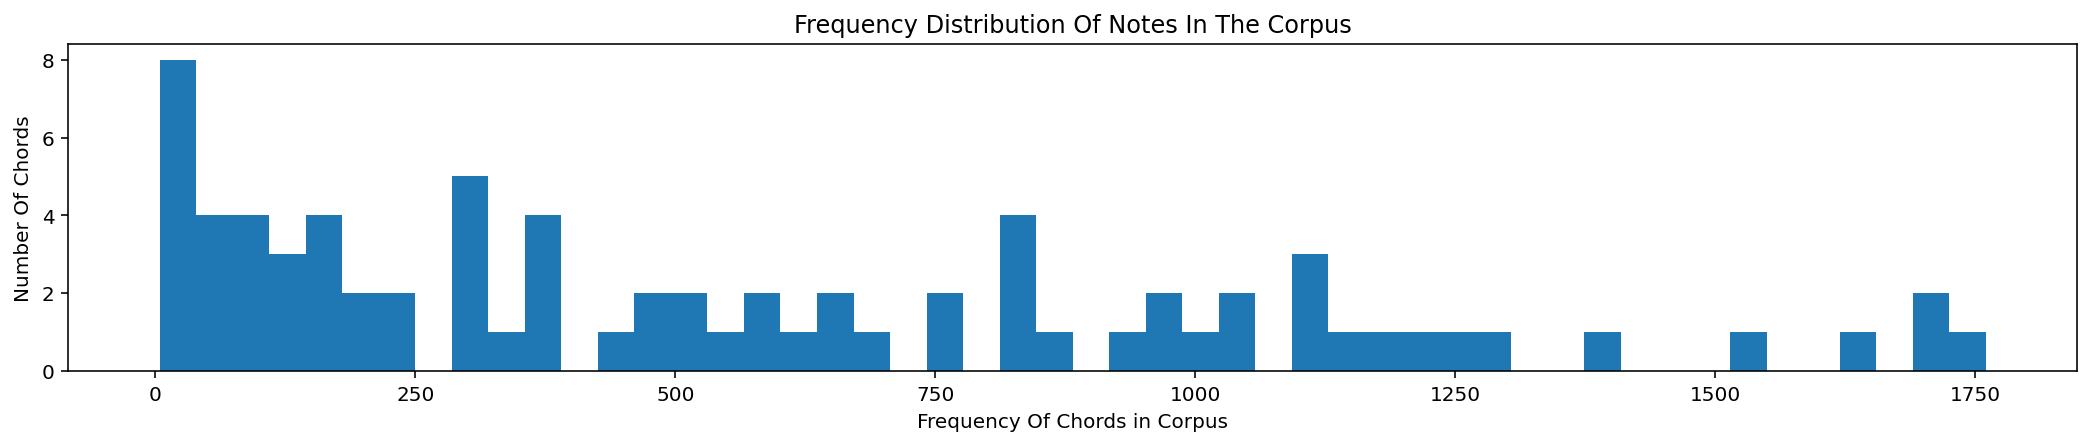

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3)) 
plt.hist(counts, bins=50)
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
        
print("Total number of notes that occur less than 10 times:", (counts<100).sum())

Total number of notes that occur less than 10 times: 16


## Preprocessing

In [ ]:
def data_split(df, 
               train_split=0.7, 
               val_split=0.2,
               seed_split=0.1,
               seq_length=40):
  """Function which takes a chronologically 
  ordered dataframe, desired sequence length,
  as well as train, validation, seed split sizes, 
  and returns train, validation and seed datasets. 
  (function ONLY works with input split
  sizes with one decimal place)"""

  num_seq = round(len(df)/(seq_length+1))
  train_df = pd.DataFrame(columns=df.columns)
  val_df = pd.DataFrame(columns=df.columns)
  seed_df = pd.DataFrame(columns=df.columns)

  for i, chunk in enumerate(np.array_split(df, num_seq)):
    if int(str(i)[-1]) < 10*train_split:
      train_df = pd.concat([train_df, chunk])
    elif int(str(i)[-1]) < 10*(train_split+val_split):
      val_df = pd.concat([val_df, chunk])
    else:
      seed_df = pd.concat([seed_df, chunk])

  train_df = train_df.reset_index().drop(columns='index').astype('float64')

  val_df = val_df.reset_index().drop(columns='index').astype('float64')

  seed_df = seed_df.reset_index().drop(columns='index').astype('float64')

  return train_df, val_df, seed_df

In [ ]:
train_df, val_df, seed_df = data_split(sample_files)

In [ ]:
train_df.to_csv(os.path.join("data", "processed_data", 
                             "processed_train.csv"))
val_df.to_csv(os.path.join("data", "processed_data", 
                           "processed_val.csv"))
seed_df.to_csv(os.path.join("data", "processed_data", 
                            "processed_seed.csv"))

In [ ]:
def df_to_dataset(df: pd.DataFrame):
  """Transforms a dataframe into a Tensorflow dataset"""
  
  cols=['pitch', 'step', 'velocity']
  dataset = np.stack([df[col] for col in cols], axis=1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)

  return dataset

In [ ]:
train_notes, val_notes, seed_notes = df_to_dataset(train_df), df_to_dataset(val_df), df_to_dataset(seed_df)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int = 40
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(['pitch', 'step', 'velocity'])}

    return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_seq_ds = create_sequences(train_notes)

val_seq_ds = create_sequences(val_notes)

seed_seq_ds = create_sequences(seed_notes)

In [ ]:
def create_batches(sequences,
                   batch_size: int=128):
  """Returns batched dataset for more efficient 
  data extraction during model training."""

  ds = (sequences
        .batch(batch_size, drop_remainder=True)
        .cache()
        .prefetch(tf.data.experimental.AUTOTUNE))
  return ds

In [ ]:
train_ds = create_batches(train_seq_ds)

val_ds = create_batches(val_seq_ds)

seed_ds = create_batches(seed_seq_ds)

## Model

In [ ]:
def instantiate_model(seq_length: int=40):
  """instantiate RNN model"""

  input_shape = (seq_length, 3)

  inputs = tf.keras.Input(input_shape)
  model = LSTM(512, return_sequences=True)(inputs)

  model = Dropout(0.1)(model)
  model = LSTM(256, return_sequences=True)(model)
  model = Dropout(0.2)(model)
  model = LSTM(128)(model)
  model = Dense(64)(model)
  model = Dropout(0.3)(model)
  outputs = {
    'pitch': Dense(88, name='pitch', activation='softmax')(model),
    'step': Dense(1, name='step')(model),
    'velocity': Dense(1, name='velocity')(model)
  }

  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = instantiate_model()

In [ ]:
tf.keras.utils.plot_model(model, 'a.png', show_shapes=True)

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
metrics = {'pitch': 'accuracy', 
           'step': 'mse',
           'velocity': 'mse'}


loss = {'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'velocity': mse_with_positive_pressure}

loss_weights={
    'pitch': 0.05,
    'step': 0.01,
    'velocity':0.001}

In [ ]:
model.compile(
    loss=loss,
    loss_weights=loss_weights,
    optimizer='rmsprop',
    metrics=metrics
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
        EarlyStopping(monitor='loss',
                      patience=20,
                      verbose=0,
                      restore_best_weights=True),
]

In [ ]:
%%time
epochs = 500

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data = val_ds
)

Epoch 1/100


TypeError: ignored

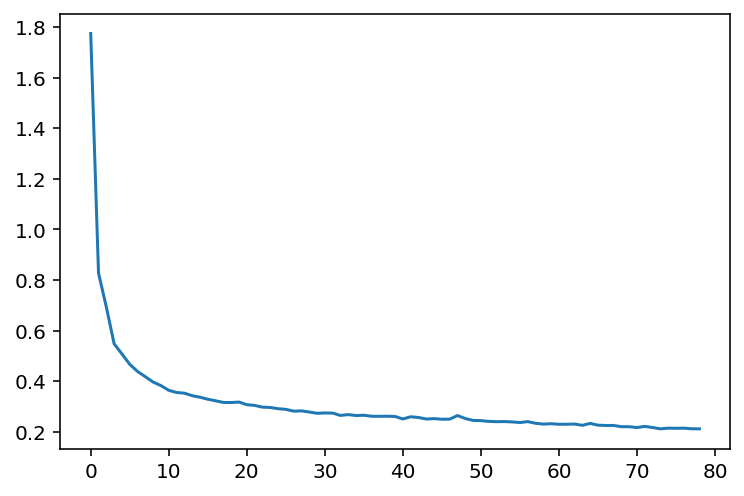

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Prediction

In [ ]:
def predict_notes(
    notes: pd.DataFrame, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0, 
    num_predictions: int=150,
    seq_length: int=40) -> pd.DataFrame:
  """Generates n following notes as a dataframe."""

  input_notes = (np.stack([notes[key] for key in ['pitch', 'step', 'velocity']], axis=1) - np.array([21, 0, 0]))[-seq_length:]
  generated_notes = []
  prev_start = 0
  for _ in range(num_predictions):
    input_notes = tf.expand_dims(input_notes, 0)
    predictions = model.predict(input_notes, verbose=0)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    velocity = predictions['velocity']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    velocity = tf.squeeze(velocity, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `velocity` values should be non-negative
    step = tf.maximum(0, step)
    velocity = tf.maximum(0, velocity)
    input_note = [np.array(pitch)[0], np.array(step)[0], np.array(velocity)[0]]
    generated_notes.append(input_note)
    input_notes = np.delete(np.squeeze(input_notes, 0), 0, axis=0)

    input_notes = np.append(input_notes, np.array(input_note, ndmin=2), axis=0)

  generated_notes = pd.DataFrame(
      generated_notes, columns=['pitch', 'step', 'velocity'])
  
  return generated_notes

In [ ]:
pred = predict_notes(processed_files[0], model)

## Audio file

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
) -> pm.PrettyMIDI:

  p = pm.PrettyMIDI()
  instrument = pm.Instrument(program=pm.instrument_name_to_program('Acoustic Grand Piano'))
  
  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + 0.27)
    note = pm.Note(
        velocity=int(note['velocity']),
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  p.instruments.append(instrument)
  p.write('file.mid')
  return p

In [ ]:
file = notes_to_midi(pred)